# Deep Averaging Networks

- Text classification
- NLTK, Textual
- Word vectors: GloVe, relativize, frozen, fine-tuning
- Feedforward Neural Networks: torch, deep averaging networks
- Initialization, dropout, Adam, batching, nonlinearity

Notes
- jupyter-notebook --NotebookApp.iopub_data_rate_limit=1.0e12
- drop Spacy in frozen dan, use GloVe for frozen and fine-tune

In [1]:
import numpy as np
import time
import re
import csv, gzip, json
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import torch
import torch.nn as nn
import random
import pickle
from finds.database.mongodb import MongoDB
from finds.unstructured import Unstructured
from finds.structured.pstat import PSTAT
from finds.unstructured.textual import Textual
from finds.misc.show import Show
from secret import credentials, paths
# %matplotlib qt
VERBOSE = 0
show = Show(ndigits=4, latex=None)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
mongodb = MongoDB(**credentials['mongodb'])
keydev = Unstructured(mongodb, 'KeyDev')
imgdir = paths['images'] / 'classify'
events_ = PSTAT._event
roles_ = PSTAT._role
memdir = paths['scratch']

{'host': 'omen3080', 'version': '5.0.20', 'process': 'mongod', 'pid': 4153196, 'uptime': 160319.0, 'uptimeMillis': 160319056, 'uptimeEstimate': 160319, 'localTime': datetime.datetime(2023, 9, 2, 14, 30, 14, 562000), 'asserts': {'regular': 0, 'warning': 0, 'msg': 0, 'user': 215, 'tripwire': 0, 'rollovers': 0}, 'catalogStats': {'collections': 7, 'capped': 0, 'timeseries': 0, 'views': 0, 'internalCollections': 3, 'internalViews': 0}, 'connections': {'current': 3, 'available': 51197, 'totalCreated': 63, 'active': 2, 'threaded': 3, 'exhaustIsMaster': 0, 'exhaustHello': 0, 'awaitingTopologyChanges': 1}, 'electionMetrics': {'stepUpCmd': {'called': 0, 'successful': 0}, 'priorityTakeover': {'called': 0, 'successful': 0}, 'catchUpTakeover': {'called': 0, 'successful': 0}, 'electionTimeout': {'called': 0, 'successful': 0}, 'freezeTimeout': {'called': 0, 'successful': 0}, 'numStepDownsCausedByHigherTerm': 0, 'numCatchUps': 0, 'numCatchUpsSucceeded': 0, 'numCatchUpsAlreadyCaughtUp': 0, 'numCatchUps

In [3]:
## Retrieve headline+situation text
events = [28, 16, 83, 41, 81, 23, 87, 45, 80, 97,  231, 46, 31, 77, 29,
          232, 101, 42, 47, 86, 93, 3, 22, 102, 82]

In [4]:
initial = False
if initial:
    lines = []
    event_all = []
    tokenizer = RegexpTokenizer(r"\b[^\d\W][^\d\W][^\d\W]+\b")
    for event in events:
        docs = keydev['events']\
               .find({'keydeveventtypeid': {'$eq': event}}, {'_id': 0})
        doc = [tokenizer.tokenize((d['headline'] + " " + d['situation'])\
                                  .lower())
               for d in docs]
        lines.extend(doc)
        event_all.extend([event] * len(doc))
    with gzip.open(memdir / 'lines.json.gz', 'wt') as f:
        json.dump(lines, f)
    with gzip.open(memdir / 'event_all.json.gz', 'wt') as f:
        json.dump(event_all, f)
    print(lines[1000000])
else:
    with gzip.open(memdir / 'lines.json.gz', 'rt') as f:
        lines = json.load(f)
    with gzip.open(memdir / 'event_all.json.gz', 'rt') as f:
        event_all = json.load(f)

In [5]:
## Encode class labels
from sklearn.preprocessing import LabelEncoder
events_encoder = LabelEncoder().fit(event_all)    # .inverse_transform()
num_classes = len(np.unique(event_all))
y_all = events_encoder.transform(event_all)
Series(event_all).value_counts()\
                 .rename(index=events_)\
                 .rename('count')\
                 .to_frame()

,count
Announcements of Earnings,244140
Executive/Board Changes - Other,128019
Private Placements,113007
Product-Related Announcements,93172
M&A Transaction Closings,90955
Client Announcements,90687
Fixed Income Offerings,69652
Dividend Affirmations,53704
M&A Transaction Announcements,43305
Special/Extraordinary Shareholders Meeting,32572


In [6]:
## Split into stratified train and test indices
from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(np.arange(len(y_all)),
                                       random_state=42,
                                       stratify=y_all,
                                       test_size=0.2)

In [7]:
## Load spacy vocab
import spacy
lang = 'en_core_web_lg'  # python -m spacy download en_core_web_lg
nlp = spacy.load(lang, disable=['parser', 'tagger', 'ner', 'lemmatizer'])
for w in ['inr', 'yen', 'jpy', 'eur', 'dkk', 'cny', 'sfr']:
    nlp.vocab[w].is_stop = True    # Mark customized stop words
n_vocab, vocab_dim = nlp.vocab.vectors.shape
print('Language:', lang, '   vocab:', n_vocab, '   dim:', vocab_dim)

Language: en_core_web_lg    vocab: 514157    dim: 300


In [8]:
## Precompute word embeddings input
def form_input(line, nlp):
    """Return spacy average vector from valid words"""
    tokens = [tok.vector for tok in nlp(" ".join(line))
              if not(tok.is_stop
                     or tok.is_punct
                     or tok.is_oov
                     or tok.is_space)]
    if len(tokens):
        return np.array(tokens).mean(axis=0)
    else:
        return np.zeros(nlp.vocab.vectors.shape[1])

In [9]:
args = {'dtype': 'float32'}
if initial:
    args.update({'shape': (len(lines), vocab_dim), 'mode': 'w+'})
    X = np.memmap(memdir / "X.{}_{}".format(*args['shape']),
                  **args)
    for i, line in tqdm(enumerate(lines)):
        X[i] = form_input(line, nlp).astype(args['dtype'])
else:
    args.update({'shape': (1224251, vocab_dim), 'mode': 'r'})
    X = np.memmap(memdir / "X.{}_{}".format(*args['shape']), **args)

In [10]:
## Pytorch Feed Forward Network
class FFNN(nn.Module):
    """Deep Averaging Network for classification"""
    def __init__(self, vocab_dim, num_classes, hidden, dropout=0.3):
        super().__init__()
        V = nn.Linear(vocab_dim, hidden[0])
        nn.init.xavier_uniform_(V.weight)
        L = [V, nn.Dropout(dropout)]
        for g, h in zip(hidden, hidden[1:] + [num_classes]):
            W = nn.Linear(g, h)
            nn.init.xavier_uniform_(W.weight)
            L.extend([nn.ReLU(), W])
        self.network = nn.Sequential(*L)
        self.classifier = nn.LogSoftmax(dim=-1)  # output is (N, C) logits

    def forward(self, x):
        """Return tensor of log probabilities"""
        return self.classifier(self.network(x))

    def predict(self, x):
        """Return predicted int class of input tensor vector"""
        return torch.argmax(self(x), dim=1).int().tolist()
            
    def save(self, filename):
        """save model state to filename"""
        return torch.save(self.state_dict(), filename)

    def load(self, filename):
        """load model name from filename"""
        self.load_state_dict(torch.load(filename, map_location='cpu'))
        return self

In [11]:
## Training Loops
accuracy = {}  # to store computed metrics
max_layers, hidden = 1, 300 #3, 300
batch_sz, lr, num_lr, step_sz, eval_skip = 64, 0.01, 4, 10, 5 #3, 3, 3 #
num_epochs = step_sz * num_lr + 1
for layers in [max_layers]:

    # Instantiate model, optimizer, scheduler, loss_function
    model = FFNN(vocab_dim=vocab_dim,
                 num_classes=num_classes,
                 hidden=[hidden]*layers)\
                 .to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                gamma=0.1,
                                                step_size=step_sz)
    loss_function = nn.NLLLoss()
    accuracy[layers] = {}

    # Loop over epochs and batches
    for epoch in range(0, num_epochs):
        tic = time.time()
        idxs = [i for i in train_idx]
        random.shuffle(idxs)
        batches = [idxs[i:(i+batch_sz)] for i in range(0, len(idxs), batch_sz)]
    
        total_loss = 0.0
        model.train()
        for i, batch in enumerate(batches):    # loop over minibatches
            x = torch.FloatTensor(np.array(X[batch]))\
                     .to(device)
            y = torch.tensor(np.array([y_all[idx] for idx in batch]))\
                     .to(device)
            model.zero_grad()                    # reset model gradient
            log_probs = model(x)                 # run model
            loss = loss_function(log_probs, y)   # compute loss
            total_loss += float(loss)
            loss.backward()      # loss step
            optimizer.step()     # optimizer step
            print(i, len(batches), i/len(batches), total_loss, end='\r')
        scheduler.step()      # scheduler step
        model.eval()
        print(f"Loss on epoch {epoch}: {total_loss:.1f}")
        #model.save(imgdir / f"dan{layers}.pt")

        with torch.no_grad():
            if epoch % eval_skip == 0:
                gold = np.asarray([int(y) for y in y_all])
                batches = [test_idx[i:(i+128)]
                           for i in range(0, len(test_idx), 128)]
                test_gold, test_pred = [], []
                for batch in tqdm(batches):
                    test_pred.extend(model.predict(
                        torch.FloatTensor(np.array(X[batch])).to(device)))
                    test_gold.extend(gold[batch])
                test_correct = (np.asarray(test_pred) ==
                                np.asarray(test_gold)).sum()

                batches = [train_idx[i:(i+128)]
                           for i in range(0, len(train_idx), 128)]
                train_gold, train_pred = [], []
                for batch in tqdm(batches):
                    train_pred.extend(model.predict(
                        torch.FloatTensor(np.array(X[batch])).to(device)))
                    train_gold.extend(gold[batch])
                train_correct = (np.asarray(train_pred) ==
                                 np.asarray(train_gold)).sum()
                accuracy[layers][epoch] = {
                    'loss': total_loss,
                    'train': train_correct/len(train_idx),
                    'test': test_correct/len(test_idx)}
                print(layers, epoch, int(time.time()-tic),
                      optimizer.param_groups[0]['lr'],
                      train_correct/len(train_idx), test_correct/len(test_idx))

Loss on epoch 0: 5324.06058546 5324.0379179120065


100%|██████████| 7652/7652 [00:01<00:00, 4865.88it/s]


1 0 16 0.01 0.8959638554216868 0.8951035527729109
Loss on epoch 1: 4997.96058546 4997.9266692250975
Loss on epoch 2: 4960.26058546 4960.1847788915045
Loss on epoch 3: 4951.46058546 4951.4285500943665
Loss on epoch 4: 4944.66058546 4944.63189046084956
Loss on epoch 5: 4945.76058546 4945.65234553441456


100%|██████████| 7652/7652 [00:01<00:00, 4897.74it/s]


1 5 12 0.01 0.9031927710843374 0.9010500263425512
Loss on epoch 6: 4958.36058546 4958.3483284115795
Loss on epoch 7: 5004.76058546 5004.72262148559155
Loss on epoch 8: 4991.26058546 4991.21699206531055
Loss on epoch 9: 4975.76058546 4975.74128325283554
Loss on epoch 10: 4215.3058546 4215.25833353400255


100%|██████████| 7652/7652 [00:01<00:00, 4860.43it/s]


1 10 12 0.001 0.9113549111701041 0.9086587353124962
Loss on epoch 11: 4087.2058546 4087.21495052054523
Loss on epoch 12: 4041.6058546 4041.59882415458565
Loss on epoch 13: 4007.9058546 4007.90326675027643
Loss on epoch 14: 3983.9058546 3983.9181403480476
Loss on epoch 15: 3965.2058546 3965.20702140033255


100%|██████████| 7652/7652 [00:01<00:00, 4981.19it/s]


1 15 12 0.001 0.9121799060649377 0.9090181375612107
Loss on epoch 16: 3943.9058546 3943.90357608720666
Loss on epoch 17: 3942.5058546 3942.53987898305065
Loss on epoch 18: 3924.0058546 3924.02518970891837
Loss on epoch 19: 3909.5058546 3909.48357108398347
Loss on epoch 20: 3840.3058546 3840.28533599725056


100%|██████████| 7652/7652 [00:01<00:00, 4891.78it/s]


1 20 13 0.0001 0.9146017970185828 0.9111541304711845
Loss on epoch 21: 3833.8058546 3833.81362865865237
Loss on epoch 22: 3826.3058546 3826.30845699086876
Loss on epoch 23: 3820.9058546 3820.91938536241655
Loss on epoch 24: 3809.1058546 3809.09616566449445
Loss on epoch 25: 3819.5058546 3819.54453152790673


100%|██████████| 7652/7652 [00:01<00:00, 4923.37it/s]


1 25 12 0.0001 0.9148284664080049 0.9113910092260191
Loss on epoch 26: 3814.8058546 3814.83310318738238
Loss on epoch 27: 3814.0058546 3813.97460565343556
Loss on epoch 28: 3812.3058546 3812.34203559532765
Loss on epoch 29: 3804.8058546 3804.80524399527353
Loss on epoch 30: 3796.5058546 3796.45055302418773


100%|██████████| 7652/7652 [00:01<00:00, 5003.26it/s]


1 30 12 1e-05 0.915077598529712 0.9114849439046604
Loss on epoch 31: 3800.5058546 3800.45695696026146
Loss on epoch 32: 3797.5058546 3797.45131069421774
Loss on epoch 33: 3800.9058546 3800.85432272194943
Loss on epoch 34: 3794.3058546 3794.28749283030637
Loss on epoch 35: 3795.6058546 3795.58340572379537


100%|██████████| 7652/7652 [00:01<00:00, 4939.08it/s]


1 35 12 1e-05 0.9150245047988564 0.911574794466839
Loss on epoch 36: 3793.1058546 3793.06682578101755
Loss on epoch 37: 3796.0058546 3796.01393349841243
Loss on epoch 38: 3803.5058546 3803.46042640507233
Loss on epoch 39: 3793.1058546 3793.09306661225865
Loss on epoch 40: 3800.3058546 3800.32398629561076


100%|██████████| 7652/7652 [00:01<00:00, 4755.91it/s]


1 40 13 1.0000000000000002e-06 0.9151000612619972 0.9114971962540483


In [12]:
from sklearn import metrics
print(model)   # show accuracy metrics for this layer
pd.concat([
    Series({'Accuracy':  metrics.accuracy_score(test_gold, test_pred),
            'Precision': metrics.precision_score(test_gold, test_pred,
                                                 average='weighted'),
            'Recall': metrics.recall_score(test_gold, test_pred,
                                           average='weighted')},
           name='Test Set').to_frame().T,      
    Series({'Accuracy': metrics.accuracy_score(train_gold, train_pred),
            'Precision': metrics.precision_score(train_gold, train_pred,
                                                 average='weighted'),
            'Recall': metrics.recall_score(train_gold, train_pred,
                                           average='weighted')},
           name='Train Set').to_frame().T], axis=0)
"""
           Accuracy  Precision    Recall
Test Set   0.910648   0.906198  0.910648
Train Set  0.914899   0.913187  0.914899

"""

FFNN(
  (network): Sequential(
    (0): Linear(in_features=300, out_features=300, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=300, out_features=25, bias=True)
  )
  (classifier): LogSoftmax(dim=-1)
)


'\n           Accuracy  Precision    Recall\nTest Set   0.910648   0.906198  0.910648\nTrain Set  0.914899   0.913187  0.914899\n\n'

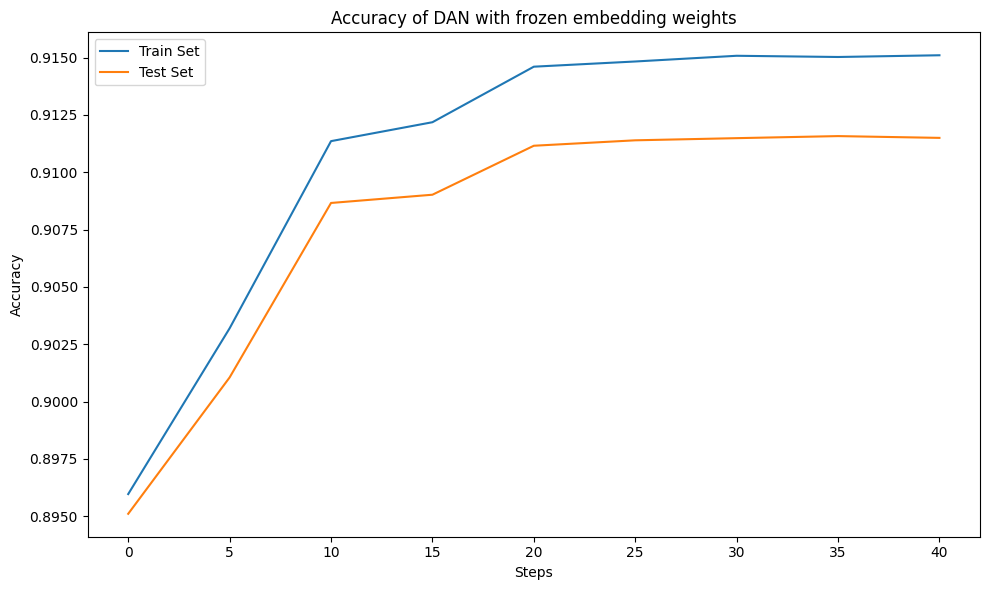

In [13]:
fig, ax = plt.subplots(num=1, clear=True, figsize=(10,6))
DataFrame.from_dict({err: {k: v[err] for k,v in accuracy[max_layers].items()}
                     for err in ['train', 'test']}).plot(ax=ax)
ax.set_title(f'Accuracy of DAN with frozen embedding weights')
ax.set_xlabel('Steps')
ax.set_ylabel('Accuracy')
ax.legend(['Train Set', 'Test Set'], loc='upper left')
plt.tight_layout()
plt.savefig(imgdir / f"frozen_accurac.jpg")

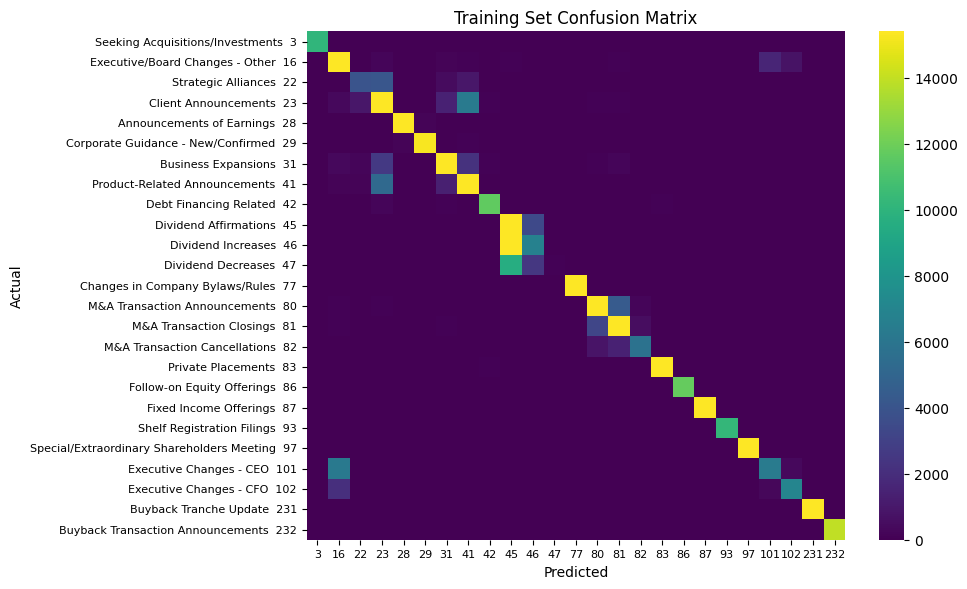

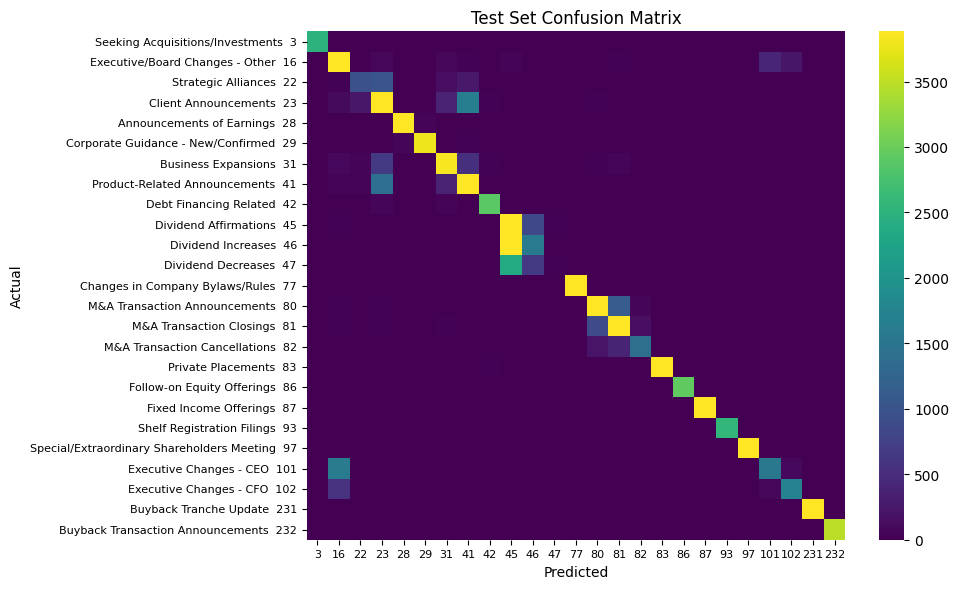

In [14]:
## Confusion Matrix
labels = [events_[e] for e in events_encoder.classes_]
cf_train = DataFrame(confusion_matrix(train_gold, train_pred),
              index=pd.MultiIndex.from_product([['Actual'], labels]),
              columns=pd.MultiIndex.from_product([['Predicted'], labels]))
cf_test = DataFrame(confusion_matrix(test_gold, test_pred),
                    index=pd.MultiIndex.from_product([['Actual'], labels]),
                    columns=pd.MultiIndex.from_product([['Predicted'], labels]))
for num, (title, cf) in enumerate({'Training':cf_train,'Test':cf_test}.items()):
    fig, ax = plt.subplots(num=1+num, clear=True, figsize=(10,6))
    sns.heatmap(cf, ax=ax, annot= False, fmt='d', cmap='viridis', robust=True,
                yticklabels=[f"{lab}  {e}" for lab, e in
                             zip(labels, events_encoder.classes_)],
                xticklabels=events_encoder.classes_)
    ax.set_title(f'{title} Set Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.yaxis.set_tick_params(labelsize=8, rotation=0)
    ax.xaxis.set_tick_params(labelsize=8, rotation=0)
    plt.subplots_adjust(left=0.35, bottom=0.25)
    plt.savefig(imgdir / f"frozen_{title}.jpg")
    plt.tight_layout()

In [ ]:
## DAN with GloVe embeddings and fine-tune weights
textdata = Textual()  # class for text pre-processing

if initial:
    vocab = textdata.counter(lines)          # count words for vocab
    textdata(vocab.most_common(20000), 0)    # vocab is most common 20000
    textdata.dump('textdata.json', imgdir)

    x_all = textdata[lines]                  # convert str docs to word indexes
    with gzip.open(imgdir / 'x_all.csv.gz', 'wt', newline="") as f:
        csv.writer(f).writerows(x_all)
else:
    x_all = []
    with gzip.open(imgdir / 'x_all.csv.gz', 'rt') as f:
        for row in csv.reader(f):
            x_all.append(row)
    textdata.load('textdata.json', imgdir)
    
# hackish convert json str to int
for i in range(len(x_all)):
    for j in range(len(x_all[i])):
        x_all[i][j] = int(x_all[i][j])
print('vocab size', textdata.n)

In [ ]:
## Relativize glove embeddings
# wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip
vocab_dim = 300
glove_prefix = paths['scratch'] / f"glove.6B.{vocab_dim}d.rel.pkl"
if initial:
    glove = textdata.relativize(glove_prefix + ".txt")
    with open(glove_prefix, "wb") as f:
        pickle.dump(glove, f)
else:
    with open(glove_prefix, "rb") as f:
        glove = pickle.load(f)
print('glove dimensions', glove.shape)

In [ ]:
## train_test split stratified by y_all
textdata.form_splits(y_all, random_state=42, test_size=0.2)

In [ ]:
## define DAN with tunable word embeddings
class DAN(nn.Module):
    """Deep Averaging Network for classification"""
    def __init__(self, vocab_dim, num_classes, hidden, embedding,
                 dropout=0.3, requires_grad=False):
        super().__init__()
        self.embedding = nn.EmbeddingBag.from_pretrained(embedding)
        self.embedding.weight.requires_grad = requires_grad
        V = nn.Linear(vocab_dim, hidden[0])
        nn.init.xavier_uniform_(V.weight)
        L = [V, nn.Dropout(dropout)]
        for g, h in zip(hidden, hidden[1:] + [num_classes]):
            W = nn.Linear(g, h)
            nn.init.xavier_uniform_(W.weight)
            L.extend([nn.ReLU(), W])
        self.network = nn.Sequential(*L)
        self.classifier = nn.LogSoftmax(dim=-1)  # output is (N, C) logits


    def tune(self, requires_grad=False):
        self.embedding.weight.requires_grad = requires_grad

    def forward(self, x):
        """Return tensor of log probabilities"""
        return self.classifier(self.network(self.embedding(x)))

    def predict(self, x):
        """Return predicted int class of input tensor vector"""
        return torch.argmax(self(x), dim=1).int().tolist()

    def save(self, filename):
        """save model state to filename"""
        return torch.save(self.state_dict(), filename)

    def load(self, filename):
        """load model name from filename"""
        self.load_state_dict(torch.load(filename, map_location='cpu'))
        return self    

In [ ]:
layers = 2
hidden = vocab_dim   #100, 300
model = DAN(vocab_dim,
            num_classes,
            hidden=[hidden]*layers,
            embedding=torch.FloatTensor(glove)).to(device)
print(model)

In [ ]:
## Training loop
accuracy = dict()
for tune in [False, True]:
    # define model, optimizer, scheduler, loss_function
    model.tune(tune)
    batch_sz, lr, num_lr, step_sz, eval_skip = 64, 0.01, 4, 5, 5 #3, 3, 3 #
    num_epochs = step_sz * num_lr + 1
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1,
                                                step_size=step_sz)
    loss_function = nn.NLLLoss()
    accuracy[tune] = dict()

    # Loop over epochs and batches
    for epoch in range(0, num_epochs):
        tic = time.time()
        batches = textdata.form_batches(batch_sz)

        total_loss = 0.0
        model.train()
        for batch in tqdm(batches):   # train by batch
            x = textdata.form_input([x_all[idx] for idx in batch]).to(device)
            y = torch.tensor([y_all[idx] for idx in batch]).to(device)
            model.zero_grad()                    # reset model gradient
            log_probs = model(x)                 # run model
            loss = loss_function(log_probs, y)   # compute loss
            total_loss += float(loss)
            loss.backward()           # loss step
            optimizer.step()          # optimizer step
        scheduler.step()          # scheduler step for learning rate
        model.eval()
        model.save(imgdir / f"danGloVe.pt")
        print(f"Loss on epoch {epoch} (tune={tune}): {total_loss:.1f}")

        with torch.no_grad():
            if epoch % eval_skip == 0:
                test_pred = [model.predict(textdata.form_input(
                    [x_all[i]]).to(device))[0] for i in textdata.test_idx]
                test_gold = [int(y_all[idx]) for idx in textdata.test_idx]
                test_correct = (np.asarray(test_pred) ==
                                np.asarray(test_gold)).sum() 
                train_pred = [model.predict(textdata.form_input(
                    [x_all[i]]).to(device))[0] for i in textdata.train_idx]
                train_gold = [int(y_all[idx]) for idx in textdata.train_idx]
                train_correct = (np.asarray(train_pred) ==
                                 np.asarray(train_gold)).sum() 
                accuracy[tune][epoch] = {
                    'loss': total_loss,
                    'train': train_correct/len(train_gold),
                    'test': test_correct/len(test_gold)}
                print(tune, epoch, int(time.time()-tic),
                      optimizer.param_groups[0]['lr'],
                      train_correct/len(train_gold),
                      test_correct/len(test_gold))

In [ ]:
## Confusion matrix
labels = [events_[e] for e in events_encoder.classes_]
cf_train = DataFrame(confusion_matrix(train_gold, train_pred),
              index=pd.MultiIndex.from_product([['Actual'], labels]),
              columns=pd.MultiIndex.from_product([['Predicted'], labels]))
cf_test = DataFrame(confusion_matrix(test_gold, test_pred),
                    index=pd.MultiIndex.from_product([['Actual'], labels]),
                    columns=pd.MultiIndex.from_product([['Predicted'], labels]))

In [ ]:
#
# First half of sample fixed weights, second half start allow tuning
#
for num, (title, cf) in enumerate({'Training':cf_train,'Test':cf_test}.items()):
    fig, ax = plt.subplots(num=1+num, clear=True, figsize=(10,6))
    sns.heatmap(cf, ax=ax, annot= False, fmt='d', cmap='viridis', robust=True,
                yticklabels=[f"{label}  {e}" for label, e in
                             zip(labels, events_encoder.classes_)],
                xticklabels=events_encoder.classes_)
    ax.set_title(f'DAN Tuned GloVe {title} Set Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.yaxis.set_tick_params(labelsize=8, rotation=0)
    ax.xaxis.set_tick_params(labelsize=8, rotation=0)
    plt.subplots_adjust(left=0.35, bottom=0.25)
    plt.savefig(imgdir / f"tuned_{title}.jpg")
    plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(num=1, clear=True, figsize=(10, 6))
DataFrame.from_dict({sample: {(tuning * len(accuracy[tuning]) + epoch):
                             acc[sample]
                             for tuning in [False, True]
                             for epoch, acc in enumerate(
                                     accuracy[tuning].values())}
                     for sample in ['train', 'test']}).plot(ax=ax)
ax.axvline((len(accuracy[False])), c='grey', alpha=0.5)
ax.set_title(f'Accuracy of DAN with fine-tuned GloVe weights')
ax.set_xlabel('Steps')
ax.set_ylabel('Accuracy')
ax.legend(['Train Set', 'Test Set','Start Fine-Tuning'], loc='upper left')
plt.tight_layout()
plt.savefig(imgdir / f"tuned_accuracy.jpg")

In [ ]:
# Exploring Spacy
"""
hashkey = nlp.vocab.strings[v]: general hash table between vocab strings and ids
vec = nlp.vocab[v].vector: np array with word embedding vector from vocab string
row = nlp.vocab.vectors.key2row: dict from word's hashkey to int

emb = nn.Embedding.from_pretrained(torch.FloatTensor(nlp.vocab.vectors.data))
emb(row) == vec : equivalence of torch embedding and spacy vector

token = nlp('king man queen woman')[0]
token.lower : hashkey
token.lower_: str
token.lex_id : row of word vector
token.has_vector : has word vector representation
"""
if False:
    doc = nlp('king queen man woman a23kj4j')
    line = [tok.lex_id for tok in doc
            if not(tok.is_stop or tok.is_punct or tok.is_oov or tok.is_space)]

    vec = (nlp.vocab['king'].vector
           - nlp.vocab['man'].vector
           + nlp.vocab['woman'].vector)
    print(vec.shape)
    sim = nlp.vocab.vectors.most_similar(vec[None,:], n=10)
    [nlp.vocab.strings[hashkey] for hashkey in sim[0][0]]

    # Load pretrained embeddings
    emb = nn.Embedding\
            .from_pretrained(torch.FloatTensor(nlp.vocab.vectors.data))

    # test for Spacy.nlp and torch.embeddings
    test_vocab = ['king', 'man', 'woman', 'queen', 'e9s82j']
    for w in test_vocab:
        vocab_id = nlp.vocab.strings[w]
        spacy_vec = nlp.vocab[w].vector
        row = nlp.vocab.vectors.key2row.get(vocab_id, None) # dict 
        if row is None:
            print('{} is oov'.format(w))
            continue
        vocab_row = torch.tensor(row, dtype=torch.long)
        embed_vec = emb(vocab_row)
        print(np.allclose(spacy_vec, embed_vec.detach().numpy()))

    for key, row in nlp.vocab.vectors.key2row.items():
        if row == 0: 
            print(nlp.vocab.strings[key])